## Introduction
##### How to get started with topic modeling using LDA in Python
** **
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

**To read more: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0**

** **
### LDA Implementation

1. [Loading data](#load_data)
2. [Data cleaning](#clean_data)
3. [Exploratory analysis](#eda)
4. [Prepare data for LDA analysis](#data_preparation)
5. [LDA model training](#train_model)
6. [Analyzing LDA model results](#results)

** **
For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **
For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

Let’s start by looking at the content of the file

In [ ]:
import zipfile
import pandas as pd
import os

# Path to the zip file
zip_file_path = "./NIPS Papers.zip"

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"The file {zip_file_path} does not exist. Please upload it to the correct location.")

# Extract the zip file into a temporary directory
temp_dir = "temp"
os.makedirs(temp_dir, exist_ok=True)  # Create the temp directory if it doesn't exist

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(temp_dir)

# Path to the CSV file
csv_file_path = os.path.join(temp_dir, "NIPS Papers", "papers.csv")

# Check if the extracted CSV file exists
if not os.path.exists(csv_file_path):
    raise FileNotFoundError(f"The file {csv_file_path} does not exist. Please check the structure of the extracted files.")

# Read the CSV file into a pandas DataFrame
papers = pd.read_csv(csv_file_path)

# Print the first few rows of the DataFrame
print(papers.head())


     id  year                                              title event_type  \
0     1  1987  Self-Organization of Associative Database and ...        NaN   
1    10  1987  A Mean Field Theory of Layer IV of Visual Cort...        NaN   
2   100  1988  Storing Covariance by the Associative Long-Ter...        NaN   
3  1000  1994  Bayesian Query Construction for Neural Network...        NaN   
4  1001  1994  Neural Network Ensembles, Cross Validation, an...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
1  10-a-mean-field-theory-of-layer-iv-of-visual-c...  Abstract Missing   
2  100-storing-covariance-by-the-associative-long...  Abstract Missing   
3  1000-bayesian-query-construction-for-neural-ne...  Abstract Missing   
4  1001-neural-network-ensembles-cross-validation...  Abstract Missing   

                                          paper_text  
0  767\n\nSELF-ORGANIZATI

In [ ]:
import zipfile
import pandas as pd
import os

# Open the zip file
with zipfile.ZipFile("./data/NIPS Papers.zip", "r") as zip_ref:
    # Extract the file to a temporary directory
    zip_ref.extractall("temp")

# Read the CSV file into a pandas DataFrame
papers = pd.read_csv("temp/NIPS Papers/papers.csv")

# Print head
papers.head()

** **
#### Step 2: Data Cleaning <a class="anchor\" id="clean_data"></a>
** **

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 100 papers

In [ ]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
831,1999,Building Predictive Models from Fractal Repres...,Abstract Missing,Building Predictive Models from Fractal\nRepre...
1136,2001,Minimax Probability Machine,Abstract Missing,Minimax Probability Machine\n\nGert R.G. Lanck...
4086,2012,On the Sample Complexity of Robust PCA,We estimate the sample complexity of a recent ...,On the Sample Complexity of Robust PCA\n\nMatt...
4601,2013,Lexical and Hierarchical Topic Regression,Inspired by a two-level theory that unifies ag...,Lexical and Hierarchical Topic Regression\n\nV...
5397,2015,Efficient Non-greedy Optimization of Decision ...,Decision trees and randomized forests are wide...,Efficient Non-greedy Optimization of Decision ...


##### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of `paper_text` column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [ ]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

,paper_text_processed
831,building predictive models from fractal\nrepre...
1136,minimax probability machine\n\ngert rg lanckri...
4086,on the sample complexity of robust pca\n\nmatt...
4601,lexical and hierarchical topic regression\n\nv...
5397,efficient non-greedy optimization of decision ...


** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

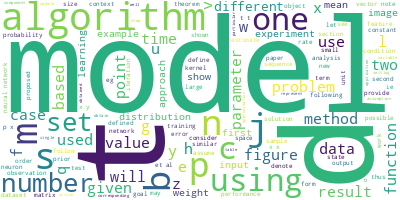

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['building', 'predictive', 'models', 'fractal', 'representations', 'symbolic', 'sequences', 'peter', 'tioo', 'georg', 'dorffner', 'austrian', 'research', 'institute', 'artificial', 'intelligence', 'schottengasse', 'vienna', 'austria', 'petertgeorg', 'aiunivieacat', 'abstract', 'propose', 'novel', 'approach', 'building', 'finite', 'memory', 'predictive', 'models']


In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 9), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 5), (24, 2), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1)]


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [ ]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"algorithm" + 0.006*"model" + 0.005*"time" + 0.005*"learning" + '
  '0.004*"data" + 0.004*"set" + 0.004*"function" + 0.003*"using" + '
  '0.003*"training" + 0.003*"models"'),
 (1,
  '0.006*"model" + 0.005*"learning" + 0.005*"function" + 0.004*"algorithm" + '
  '0.004*"data" + 0.004*"number" + 0.004*"figure" + 0.004*"one" + 0.004*"set" '
  '+ 0.004*"training"'),
 (2,
  '0.005*"model" + 0.005*"data" + 0.005*"set" + 0.005*"time" + '
  '0.004*"learning" + 0.004*"algorithm" + 0.003*"training" + 0.003*"two" + '
  '0.003*"number" + 0.003*"used"'),
 (3,
  '0.006*"model" + 0.005*"learning" + 0.005*"data" + 0.005*"time" + '
  '0.004*"algorithm" + 0.004*"set" + 0.004*"using" + 0.004*"one" + '
  '0.003*"based" + 0.003*"figure"'),
 (4,
  '0.005*"using" + 0.005*"algorithm" + 0.004*"set" + 0.004*"number" + '
  '0.004*"learning" + 0.004*"one" + 0.004*"data" + 0.004*"time" + '
  '0.004*"figure" + 0.004*"function"'),
 (5,
  '0.006*"algorithm" + 0.006*"learning" + 0.005*"model" + 0.004*"tim

** **
#### Step 6: Analyzing our LDA model <a class="anchor\" id="results"></a>
** **

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [ ]:
!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# Create the 'results' directory if it doesn't exist
os.makedirs('./results', exist_ok=True)  # This line is added to create the directory


# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.010748 -0.001351       1        1  25.398878
1     -0.000381 -0.009348       2        1  15.848127
7     -0.006757  0.001485       3        1  13.414655
5      0.004397  0.004653       4        1  10.908174
6      0.001622  0.000923       5        1   9.290260
3     -0.006361 -0.003070       6        1   6.652055
2     -0.007995  0.004275       7        1   5.858240
9      0.005932  0.005331       8        1   5.716513
4      0.001823 -0.005507       9        1   3.467610
0     -0.003027  0.002610      10        1   3.445487, topic_info=            Term         Freq        Total Category  logprob  loglift
17     algorithm  1242.000000  1242.000000  Default  30.0000  30.0000
683         time   849.000000   849.000000  Default  29.0000  29.0000
403        model  1328.000000  1328.000000  Default  28.0000  28.0000
583          set  1006.000000  1006.000000  Default  27.0000  27.0000
724        using   777.000000   777.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
427          one    20.002522   786.426510  Topic10  -5.9511  -0.3035
421       number    19.582434   797.176995  Topic10  -5.9723  -0.3383
1225  algorithms    15.314764   435.925389  Topic10  -6.2181   0.0195
173    different    15.646226   477.907993  Topic10  -6.1967  -0.0511
495      problem    17.014523   689.451989  Topic10  -6.1129  -0.3337

[865 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
9844       4  0.366267  acceptability
11125      3  0.280127         accrue
773        1  0.293387       accuracy
773        2  0.119528       accuracy
773        3  0.097796       accuracy
...      ...       ...            ...
5642       6  0.018072             zt
5642       7  0.027108             zt
5642       8  0.108433             zt
5642       9  0.036144             zt
5642      10  0.018072             zt

[3875 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 8, 6, 7, 4, 3, 10, 5, 1])

** **
#### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this article addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### References:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf
